In [1]:
pip install gudhi -q

     |████████████████████████████████| 29.3 MB 1.2 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx 
from tqdm.auto import tqdm
import copy
import gudhi  
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn') 

## Обработка данных

In [4]:
df = pd.read_excel('assoc_eng2.xlsx', sheet_name='Sheet1')
#df = pd.read_excel('/Users/tatianazabrodina/Desktop/Универ/мага/2021_2022/ проект/assoc_eng2.xlsx', sheet_name='Sheet1')
df = df.drop(columns = ['Unnamed: 0'], axis = 1) 
df = df[df.source != df.target].reset_index(drop=True)
df['node_id'] = df.apply(lambda x: '_'.join(sorted((x.source, x.target))), axis=1)

In [5]:
new_df = df.sort_values(['node_id', 'weight'])\
           .drop_duplicates('node_id', keep='last')\
           .drop('node_id', axis=1)\
           .sort_values(['source', 'target'])\
           .reset_index(drop=True)

In [6]:
new_df.head()

,source,target,weight
0,a,alphabet,0.066
1,a,apple,0.013
2,a,great,0.013
3,a,letter,0.039
4,a,one,0.013


In [7]:
nodes = pd.unique(pd.concat([new_df['source'], new_df['target']]))
weight_edges = list(new_df['weight'])

In [8]:
#симметричная матрица весов 
A = np.zeros((len(nodes),len(nodes)))
for i, edge in enumerate(zip(new_df['source'],new_df['target'])):
    n1, n2 = edge
    ind1 = np.where(nodes == n1)[0][0]
    ind2 = np.where(nodes == n2)[0][0]
    A[ind1][ind2] = weight_edges[i]
    A[ind2][ind1] = weight_edges[i]

## Рандомизация

### def

In [9]:
#допишем списки чисел бетти до одной длины
def res_dop_Nan(res):
    res_copy = copy.deepcopy(res)
    for i in range(len(res_copy)):
        if res_copy[i][1][-1]==0:
            res_copy[i][1][-1]=None
    for i in range(len(res_copy)):
        if len(res_copy[i][1])==1:
            res_copy[i][1].append(None)
            res_copy[i][1].append(None)
        elif len(res_copy[i][1])==2:
            res_copy[i][1].append(None)
    return res_copy

In [10]:
def betti_numbers_and_dops(A, max_k, count_k):
    res_betti = []
    #res_components = []
    res_lcg = []
    N = len(A)
    E = np.ones_like(A)

    for k in tqdm(np.linspace(0, max_k, count_k)[::-1]): #IVR
        B = copy.deepcopy(A)
        B = B * (B > k)#  IVR
        if not B.any():
            continue

        G = nx.from_numpy_array(B)

        LCG=G.subgraph(max(nx.connected_components(G), key=len))#максимальная компонента
        res_lcg.append((LCG.number_of_nodes(),LCG.number_of_edges()))

        B = E - B
        rips_complex = gudhi.RipsComplex(distance_matrix=B, max_edge_length=B.max() - 1e-9)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
        diag = simplex_tree.persistence()
        res_betti.append([k, simplex_tree.betti_numbers()])
        
    return res_betti,res_lcg#res_components,res_lcg

In [11]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

In [12]:
def random_edges_in_matrix_weight(Matrix_weight,f):#Q - кол-во перестановок f - доля
    W = Matrix_weight.copy()
    edges = np.where(np.triu(W))
    weights = W[edges]
    Q = int(np.round(f*len(weights),0))
    for m in range(Q):
        t=0
        while t==0:
            i, j = np.random.choice(len(weights),2,replace=False)
            if (edges[0][i]!=edges[0][j])&(edges[0][i]!=edges[1][j])&(edges[1][i]!=edges[0][j])&(edges[1][i]!=edges[1][j]):
                edges[0][i], edges[0][j] = edges[0][j], edges[0][i]
                weights[i], weights[j] = weights[j], weights[i]
                t+=1
            else:
                t=0

    W_new = np.zeros_like(W)
    W_new[edges] = weights
    W_new[edges[::-1]] = weights

    return W_new

In [13]:
def results_of_random(A,max_doly_random,num_random,max_k,count_k):
    res_betti_all = []
    #res_components_all = []
    res_lcg_all = []

    for i in tqdm(np.linspace(0, max_doly_random, num_random)):
        matr = random_edges_in_matrix_weight(A,i)
        res_betti_,res_lcg_ = betti_numbers_and_dops(matr, max_k, count_k)
        res_betti_all.append(res_betti_)
        res_lcg_all.append(res_lcg_)
    return res_betti_all,res_lcg_all

In [14]:
def plot_of_betti_numbers(res_betti_all,arr_random, start_0=1, start_1=1, start_2=1):
    fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(20, 18))
    cmap = get_cmap(len(arr_random)+1)
#Zero Betti number
    for n in range(len(arr_random)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        betti1 = [i[1][0] for i in res_copy_rand]
        ax[0][0].scatter(ks, betti1,label=(str(int(arr_random[n]*100))+' %'), color=cmap(n), s=15)
    ax[0][0].set_title('$β_{0}$', fontsize=16)
    ax[0][0].set_xlabel("Пороговое значение веса", fontsize=14)
    ax[0][0].set_ylabel("$β_{0}$", fontsize=14)
    ax[0][0].legend(title='Рандомизация')
    ax[0][0].set_xlim(1,0-0.03)

    for n in range(len(arr_random)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        betti1 = [i[1][0] for i in res_copy_rand]
        ax[1][0].scatter(ks, betti1,label=(str(int(arr_random[n]*100))+' %'), color=cmap(n), s=15)
    ax[1][0].set_title('$β_{0}$', fontsize=16)
    ax[1][0].set_xlabel("Пороговое значение веса", fontsize=14)
    ax[1][0].set_ylabel("$β_{0}$ \n(log шкала)", fontsize=14)
    ax[1][0].legend(title='Рандомизация')
    ax[1][0].set_yscale('log')
    ax[1][0].set_xlim(start_0,0-0.03)

    for n in range(len(arr_random)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        betti1 = [i[1][0] for i in res_copy_rand]
        ax[2][0].plot(ks, betti1, 'o--',label=(str(int(arr_random[n]*100))+' %'), color=cmap(n))
    ax[2][0].set_title('$β_{0}$', fontsize=16)
    ax[2][0].set_xlabel("Пороговое значение веса", fontsize=14)
    ax[2][0].set_ylabel("$β_{0}$ \n(log шкала)", fontsize=14)
    ax[2][0].legend(title='Рандомизация')
    ax[2][0].set_yscale('log')
    ax[2][0].set_xlim(start_0,0-0.03)

#First Betti numbers
    for n in range(len(arr_random)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        betti2 = [i[1][1] for i in res_copy_rand]
        ax[0][1].scatter(ks, betti2,label=(str(int(arr_random[n]*100))+' %'), color=cmap(n), s=15)
    ax[0][1].set_title('$β_{1}$', fontsize=16)
    ax[0][1].set_xlabel("Пороговое значение веса", fontsize=14)
    ax[0][1].set_ylabel("$β_{1}$", fontsize=14)
    ax[0][1].legend(title='Рандомизация')
    ax[0][1].set_xlim(1,0-0.03)

    for n in range(len(arr_random)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        betti2 = [i[1][1] for i in res_copy_rand]
        ax[1][1].scatter(ks, betti2,label=(str(int(arr_random[n]*100))+' %'), color=cmap(n), s=20)
    ax[1][1].set_title('$β_{1}$', fontsize=16)
    ax[1][1].set_xlabel("Пороговое значение веса", fontsize=14)
    ax[1][1].set_ylabel("$β_{1}$ \n(log шкала)", fontsize=14)
    ax[1][1].legend(title='Рандомизация')
    ax[1][1].set_yscale('log')
    ax[1][1].set_xlim(start_1,0-0.03)

    for n in range(len(arr_random)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        betti2 = [i[1][1] for i in res_copy_rand]
        ax[2][1].plot(ks, betti2, 'o--',label=(str(int(arr_random[n]*100))+' %'), color=cmap(n))
    ax[2][1].set_title('$β_{1}$', fontsize=16)
    ax[2][1].set_xlabel("Пороговое значение веса", fontsize=14)
    ax[2][1].set_ylabel("$β_{1}$ \n(log шкала)", fontsize=14)
    ax[2][1].legend(title='Рандомизация')
    ax[2][1].set_yscale('log')
    ax[2][1].set_xlim(start_1,0-0.03)

#Second Betti numbers
    for n in range(len(arr_random)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        betti3 = [i[1][2] for i in res_copy_rand]
        ax[0][2].scatter(ks, betti3,label=(str(int(arr_random[n]*100))+' %'), color=cmap(n), s=15)
    ax[0][2].set_title('$β_{2}$', fontsize=16)
    ax[0][2].set_xlabel("Пороговое значение веса", fontsize=14)
    ax[0][2].set_ylabel("$β_{2}$", fontsize=14)
    ax[0][2].legend(title='Рандомизация')
    ax[0][2].set_xlim(1,0-0.03)

    for n in range(len(arr_random)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        betti3 = [i[1][2] for i in res_copy_rand]
        ax[1][2].scatter(ks, betti3,label=(str(int(arr_random[n]*100))+' %'), color=cmap(n), s=20)
    ax[1][2].set_title('$β_{2}$', fontsize=16)
    ax[1][2].set_xlabel("Пороговое значение веса", fontsize=14)
    ax[1][2].set_ylabel("$β_{2}$ \n(log шкала)", fontsize=14)
    ax[1][2].legend(title='Рандомизация')
    ax[1][2].set_yscale('log')
    ax[1][2].set_xlim(start_2,0-0.03)

    for n in range(len(arr_random)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        betti3 = [i[1][2] for i in res_copy_rand]
        ax[2][2].plot(ks, betti3, 'o--',label=(str(int(arr_random[n]*100))+' %'), color=cmap(n))
    ax[2][2].set_title('$β_{2}$', fontsize=16)
    ax[2][2].set_xlabel("Пороговое значение веса", fontsize=14)
    ax[2][2].set_ylabel("$β_{2}$ \n(log шкала)", fontsize=14)
    ax[2][2].legend(title='Рандомизация')
    ax[2][2].set_yscale('log')
    ax[2][2].set_xlim(start_2,0-0.03)

    plt.subplots_adjust(hspace=0.35, wspace=0.2)
    plt.show()

In [15]:
def plot_of_dops_random(res_betti_all, arr_random, res_lcg_all, start_size_max_component=1):
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 5))
    cmap = get_cmap(len(arr_random)+1)
    res_copy_rand = res_dop_Nan(res_betti_all[0])
    ks = [i[0] for i in res_copy_rand]

    for n in range(len(arr_random)):    
        ax[0].scatter(ks, [i[0] for i in res_lcg_all[n]],color=cmap(n),label=(str(int(arr_random[n]*100))+' %'), s=15)
        ax[1].scatter(ks, [i[0] for i in res_lcg_all[n]],color=cmap(n),label=(str(int(arr_random[n]*100))+' %'), s=15)
        ax[2].plot(ks, [i[0] for i in res_lcg_all[n]], 'o--',color=cmap(n),label=(str(int(arr_random[n]*100))+' %'))

    ax[0].set_xlabel("Пороговое значение веса", fontsize=12)
    ax[0].set_ylabel("Кол-во вершин", fontsize=12)
    ax[0].set_title("Размер максимальной компоненты", fontsize=14)
    ax[0].legend(title='Рандомизация')
    ax[0].set_xlim(1,0-0.03)

    ax[1].set_xlabel("Пороговое значение веса", fontsize=12)
    ax[1].set_ylabel("Кол-во вершин \n(log шкала)", fontsize=12)
    ax[1].set_title("Размер максимальной компоненты", fontsize=14)
    ax[1].set_yscale('log')
    ax[1].legend(title='Рандомизация')
    ax[1].set_xlim(start_size_max_component,0-0.03)

    ax[2].set_xlabel("Пороговое значение веса", fontsize=12)
    ax[2].set_ylabel("Кол-во вершин \n(log шкала)", fontsize=12)
    ax[2].set_title("Размер максимальной компоненты", fontsize=14)
    ax[2].set_yscale('log')
    ax[2].legend(title='Рандомизация')
    ax[2].set_xlim(start_size_max_component,0-0.03)

    plt.subplots_adjust(hspace=0.35, wspace=0.2)
    plt.show()

### plot

In [152]:
max_doly_random = 5
num_random = 10
max_k = 1
count_k = 100
arr_random = np.linspace(0, max_doly_random, num_random)
res_betti_all_5,res_lcg_all_5=results_of_random(A,max_doly_random,num_random,max_k,count_k)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

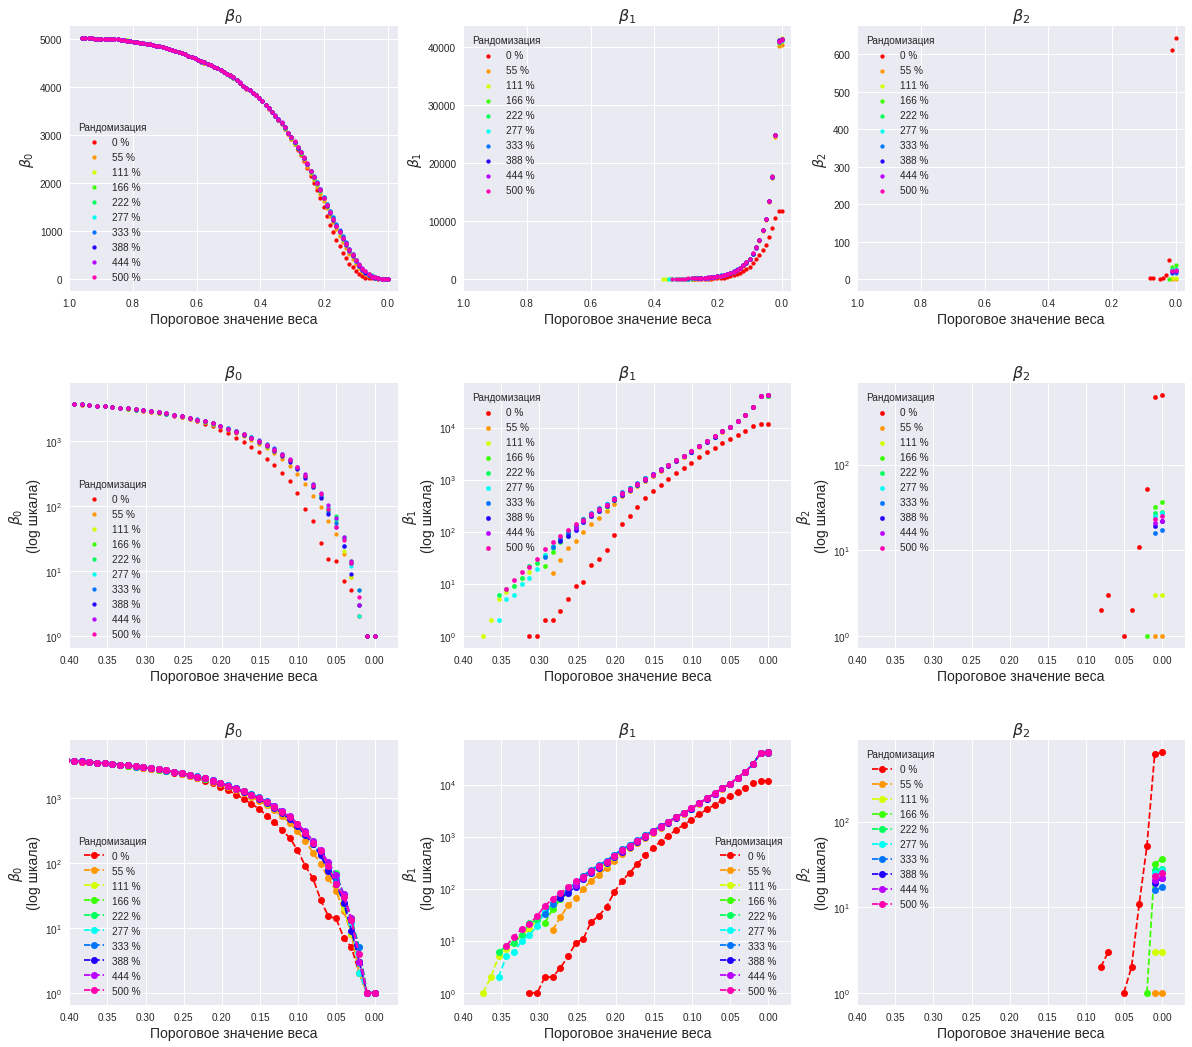

In [154]:
plot_of_betti_numbers(res_betti_all_5,arr_random,0.4,0.4,0.4)

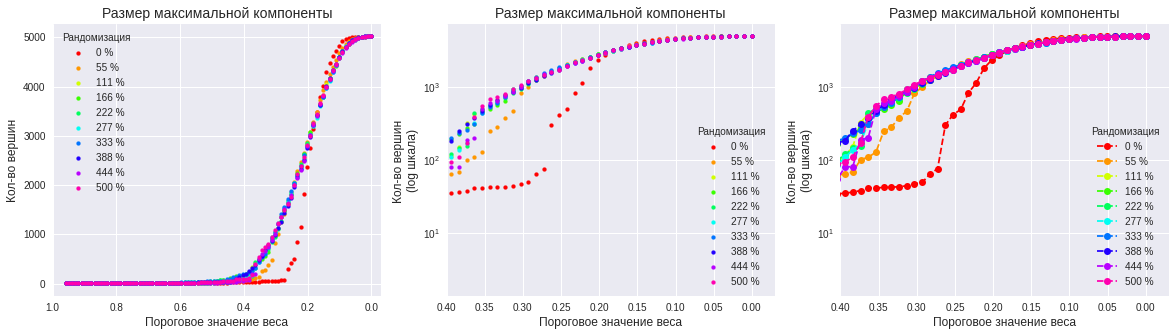

In [155]:
plot_of_dops_random(res_betti_all_5, arr_random, res_lcg_all_5,0.4)

In [145]:
max_doly_random = 0.5
num_random = 5
max_k = 1
count_k = 100
arr_random = np.linspace(0, max_doly_random, num_random)
res_betti_all_2,res_lcg_all_2=results_of_random(A,max_doly_random,num_random,max_k,count_k)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

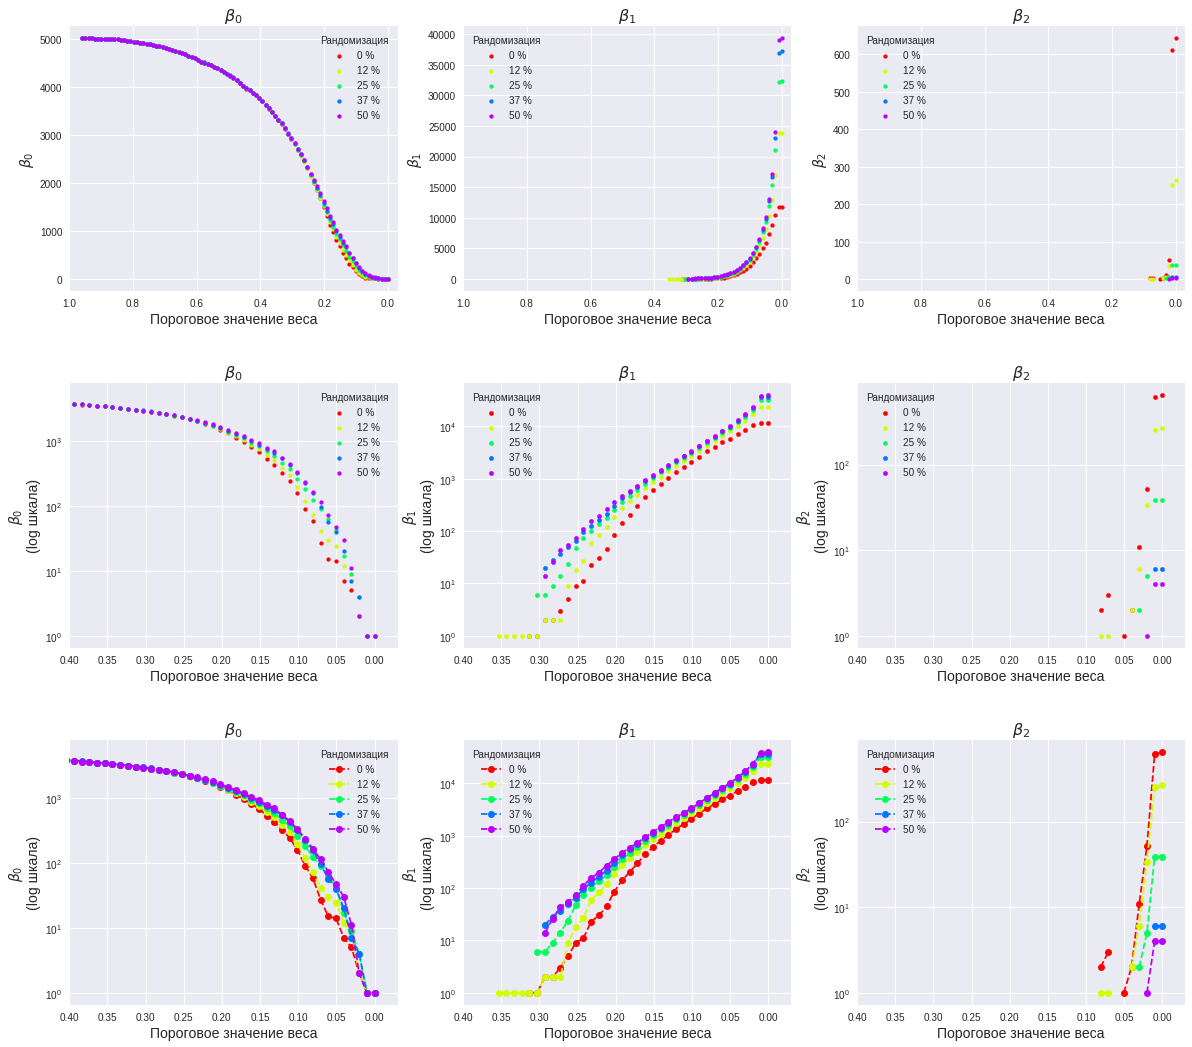

In [157]:
plot_of_betti_numbers(res_betti_all_2,arr_random,0.4,0.4,0.4)

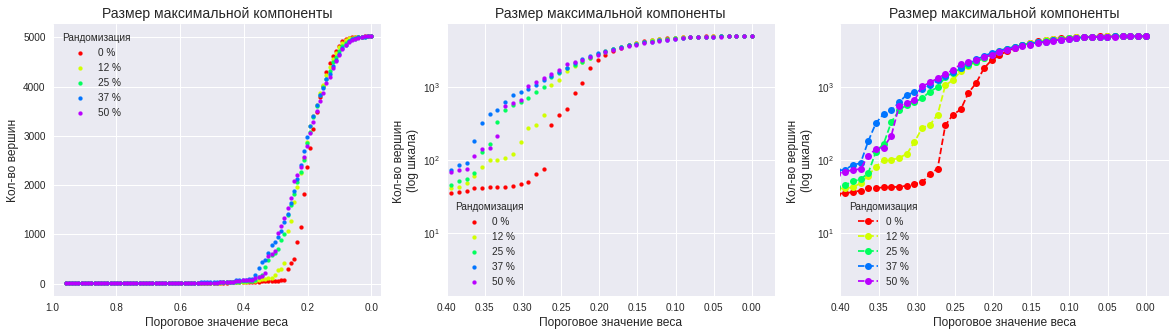

In [151]:
plot_of_dops_random(res_betti_all_2, arr_random, res_lcg_all_2,0.4)

## k-core

### def

In [16]:
#k-core
def k_core(G):
    kg_arr = []
    k=1
    kG=nx.k_core(G,k)
    while len(list(kG))!=0:
        kG=nx.k_core(G,k)
        kG=[int(i) for i in kG]
        kg_arr.append((k,len(kG)))
        k+=1

    return kg_arr

In [17]:
def betti_numbers_and_dops_with_k_core(A, max_k, count_k):
    res_betti = []
    res_k_core = []
    N = len(A)
    E = np.ones_like(A)

    for k in tqdm(np.linspace(0, max_k, count_k)[::-1]):
        B = copy.deepcopy(A)
        B = B * (B > k)
        if not B.any():
            continue


        G = nx.from_numpy_array(B)

        k_cores = k_core(G)
        res_k_core.append(k_cores)

        B = E - B
        rips_complex = gudhi.RipsComplex(distance_matrix=B, max_edge_length=B.max() - 1e-9)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
        diag = simplex_tree.persistence()
        res_betti.append([k, simplex_tree.betti_numbers()])
        
    return res_betti,res_k_core#res_components,res_lcg, res_k_core

In [18]:
def results_of_random_and_kcore(A, max_doly_random, num_random, max_k, count_k):
    res_betti_all = []
    #res_lcg_all = []
    res_k_core_all = []
    arr_random_doly = np.linspace(0, max_doly_random, num_random)

    for i in tqdm(arr_random_doly):
        matr = random_edges_in_matrix_weight(A,i)
        res_betti_,res_k_core_ = betti_numbers_and_dops_with_k_core(matr, max_k, count_k)
        res_betti_all.append(res_betti_)
        res_k_core_all.append(res_k_core_)
    return res_betti_all, res_k_core_all

In [19]:
def data_kcore(res_k_core_all,graph_id):
    max_size_kcore = max(map(len, res_k_core_all[graph_id]))

    plot_data = np.zeros((len(res_k_core_all[graph_id]), max_size_kcore))

    for i, raw in enumerate(res_k_core_all[graph_id]):
        for j in range(max_size_kcore):
            if len(raw) > j:
                plot_data[i, j] = raw[j][1]
            else:
                plot_data[i, j] = None
    return plot_data

In [20]:
def plot_kcore(arr_random, res_k_core_all, max_k, count_k):
    for i in range(len(res_k_core_all)):
        data = data_kcore(res_k_core_all,i)
        cmap = get_cmap(len(data)+1)
        fig = plt.figure(figsize=(10, 7))
        labels = np.linspace(0, max_k, count_k)[:len(data)][::-1]
        for n in range(len(data)):
            x = range(len(data[n]))

            plt.plot(x, data[n],marker='o',c=cmap(n),label=np.round(labels[n],2))

        plt.title(('Рандомизация '+str(int(arr_random[i]*100))+' %'), fontsize=16)
        plt.xlabel('Размер k-core', fontsize=14)
        plt.ylabel('Кол-во вершин', fontsize=14)
        plt.legend(title='пороговое значение веса')

In [21]:
def plot_kcore_all_in_one(arr_random, res_k_core_all, max_k, count_k):
    fig = plt.figure(figsize=(20, 10))
    for i in range(len(res_k_core_all)):
        if i==0:
            data = data_kcore(res_k_core_all,i)
            cmap = get_cmap(len(data)+1)
            for n in range(len(data)):
                labels = np.linspace(0, max_k, count_k)[:len(data)][::-1]
                x = range(len(data[n]))
                plt.plot(x, data[n], '--',marker='o',c=cmap(n),label=(str(np.round(labels[n],2))+' (без рандомизации)'))

        elif i==len(res_k_core_all)-1:
            data = data_kcore(res_k_core_all,i)
            cmap = get_cmap(len(data)+1)
            for n in range(len(data)):
                labels = np.linspace(0, max_k, count_k)[:len(data)][::-1]
                x = range(len(data[n]))
                plt.plot(x, data[n], ':',marker='o',c=cmap(n),label=(str(np.round(labels[n],2))+' (максимальная рандомизация = '+str(int(arr_random[i]*100)))+'%)')        

        else:
            data = data_kcore(res_k_core_all,i)
            cmap = get_cmap(len(data)+1)
            for n in range(len(data)):
                labels = np.linspace(0, max_k, count_k)[:len(data)][::-1]
                x = range(len(data[n]))
                plt.plot(x, data[n], marker='o',c=cmap(n))#,label=np.round(labels[n],2))

        #plt.title(('Доля рандомизации = '+str(np.round(arr_random[i],2))), fontsize=16)
        plt.xlabel('Размер k-core', fontsize=14)
        plt.ylabel('Кол-во вершин', fontsize=14)
        plt.legend(title='пороговое значение веса')#, loc='right')
    plt.title('Все рандомизации', fontsize=16)

### plot

In [164]:
max_doly_random = 0.5
num_random = 5
max_k = 1
count_k = 10
arr_random = np.linspace(0, max_doly_random, num_random)
res_betti_all, res_k_core_all = results_of_random_and_kcore(A,max_doly_random,num_random,max_k,count_k)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

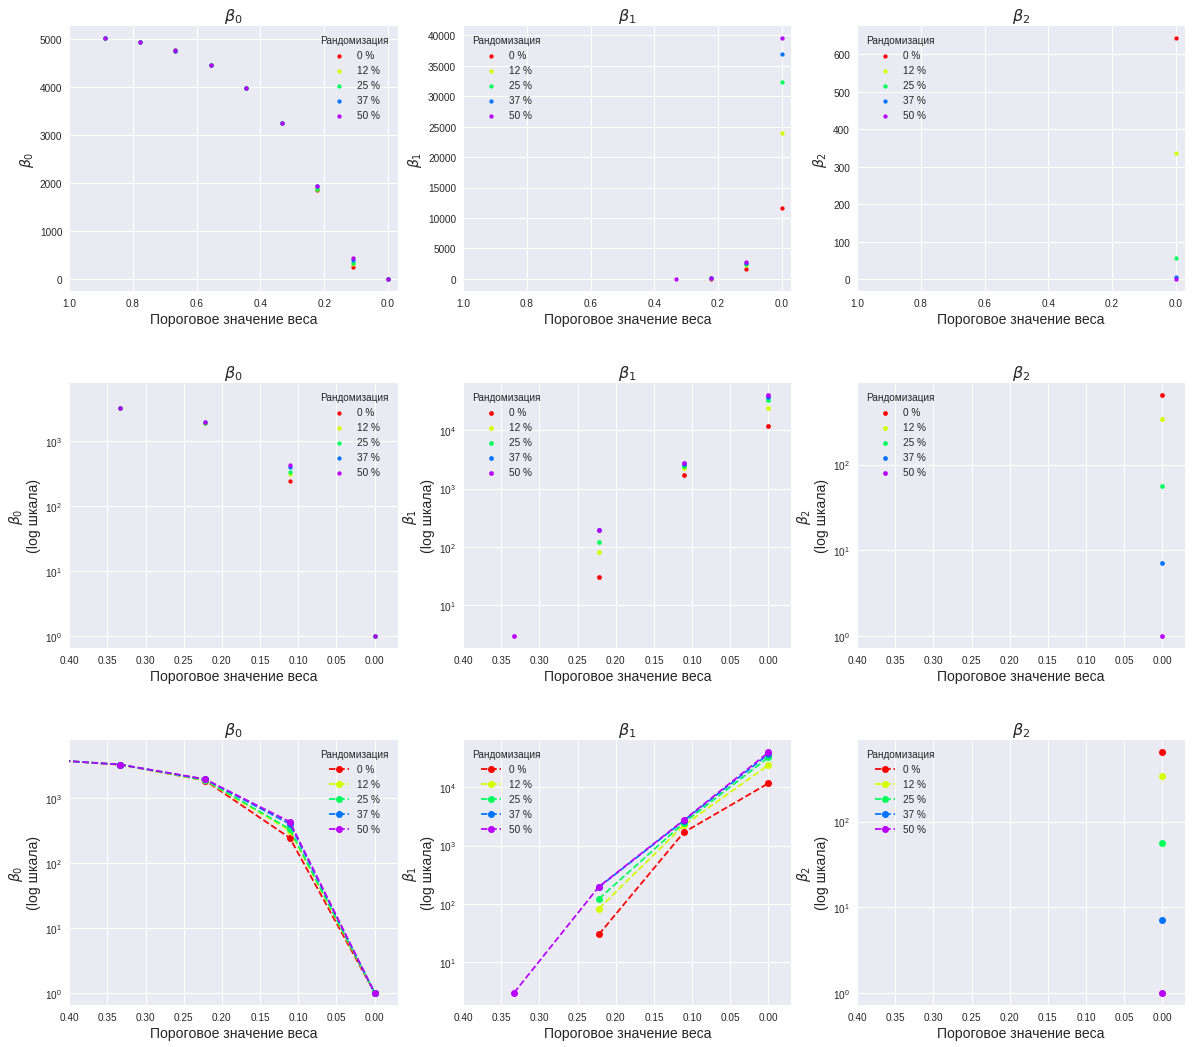

In [165]:
plot_of_betti_numbers(res_betti_all,arr_random,0.4,0.4,0.4)

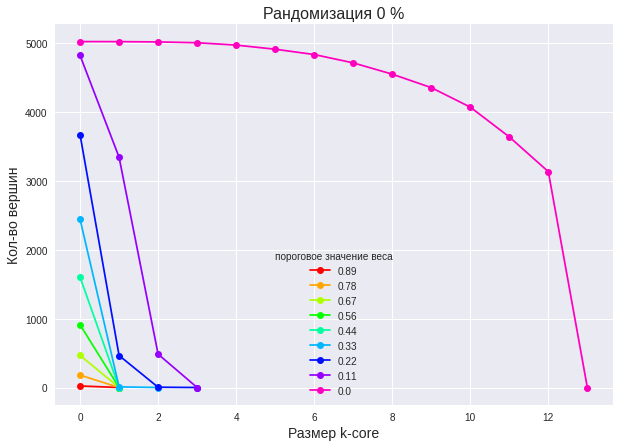

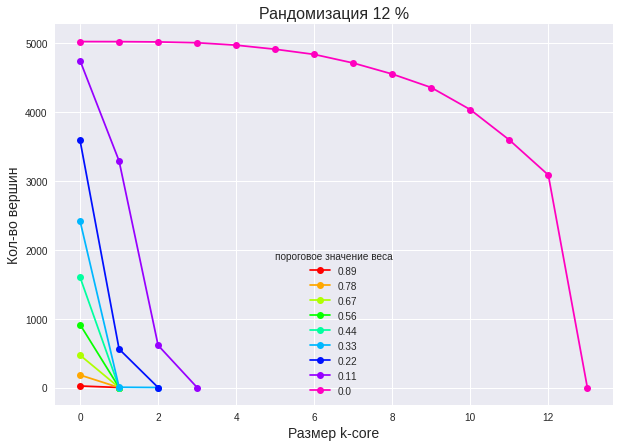

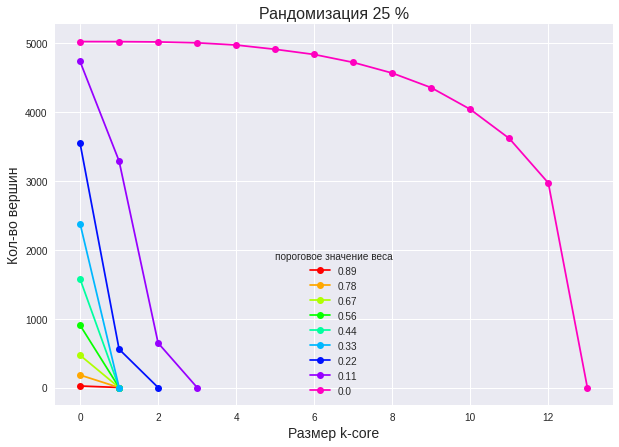

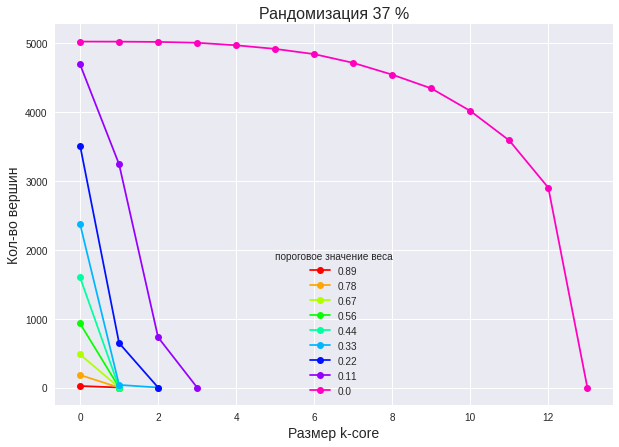

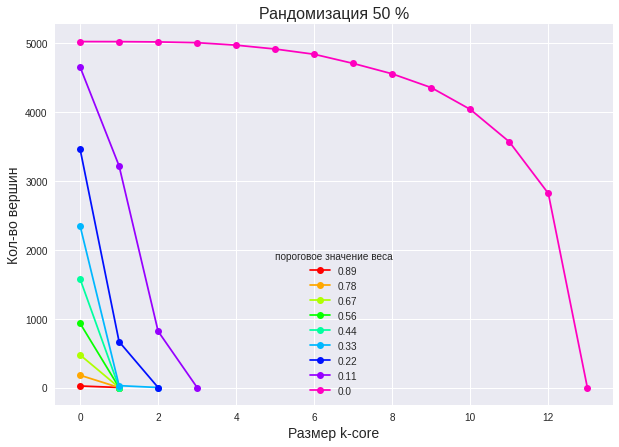

In [166]:
plot_kcore(arr_random, res_k_core_all, max_k, count_k)

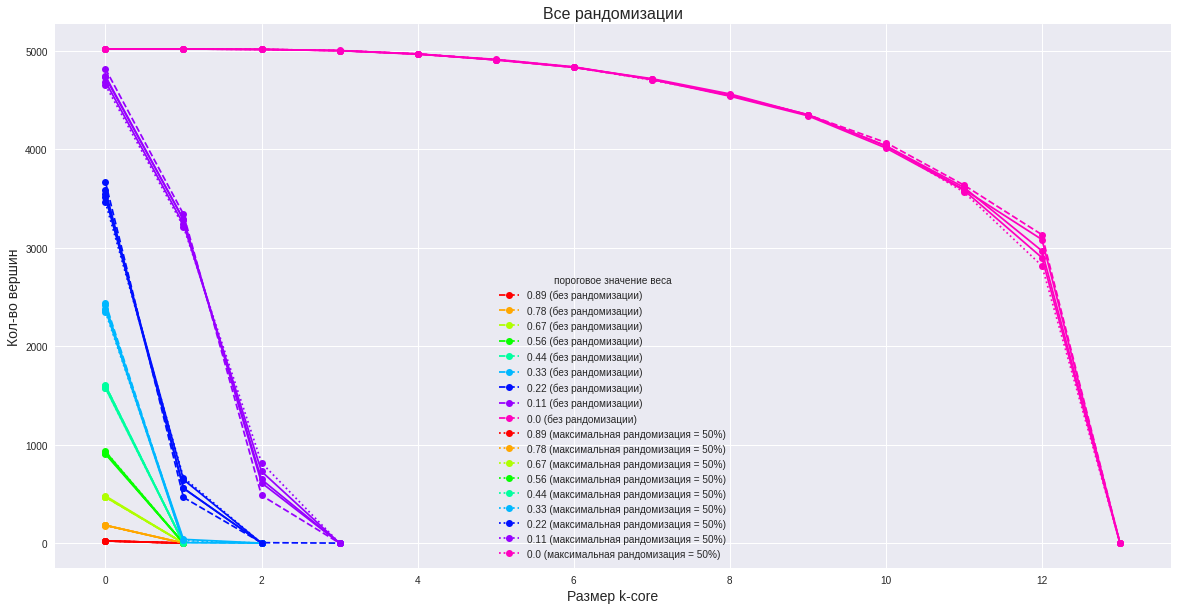

In [167]:
plot_kcore_all_in_one(arr_random, res_k_core_all, max_k, count_k)

In [168]:
max_doly_random = 5
num_random = 5
max_k = 1
count_k = 10
arr_random = np.linspace(0, max_doly_random, num_random)
res_betti_all_r5, res_k_core_all_r5 = results_of_random_and_kcore(A,max_doly_random,num_random,max_k,count_k)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

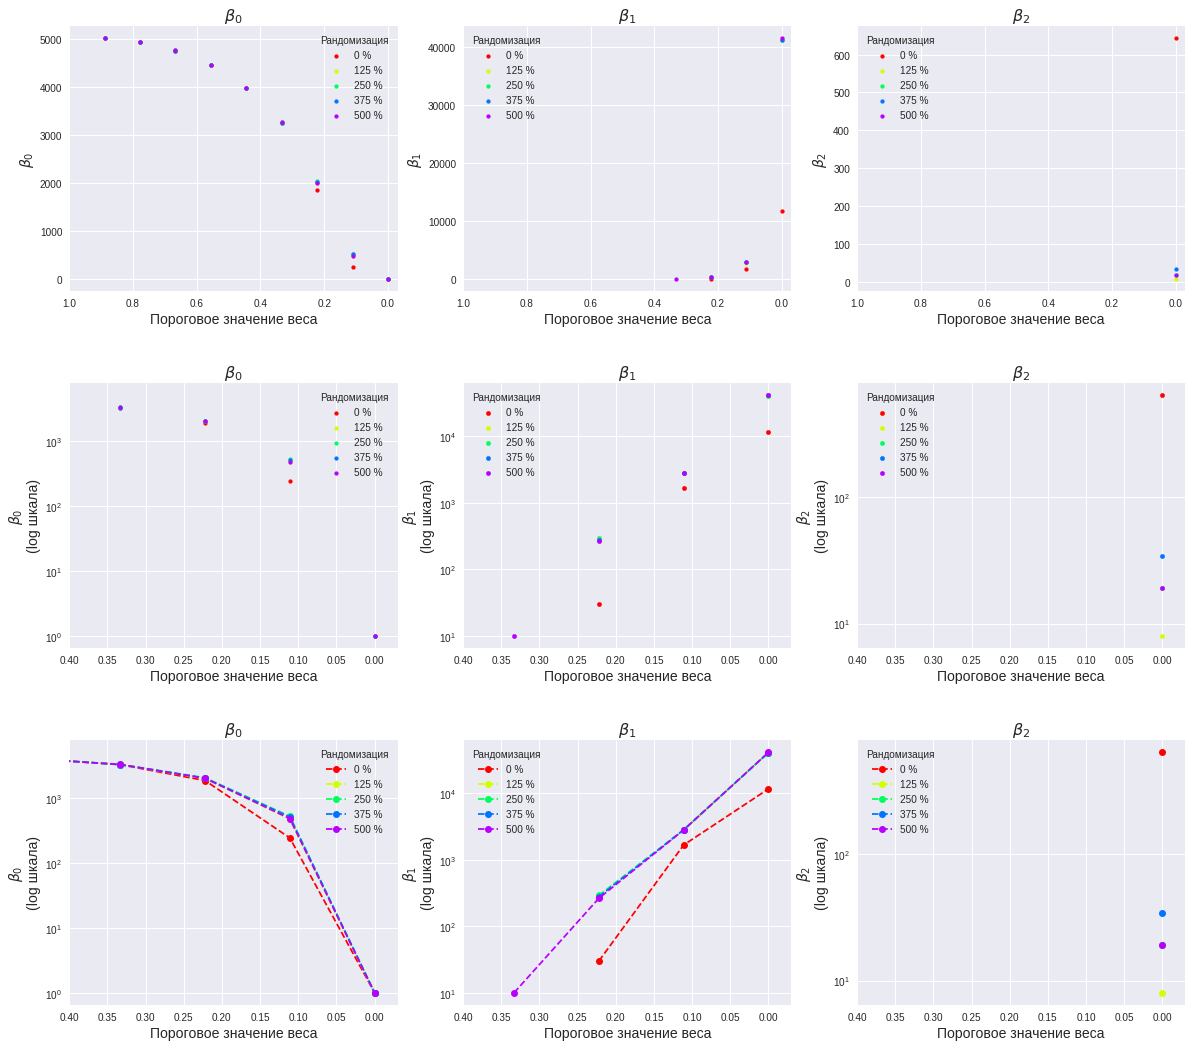

In [169]:
plot_of_betti_numbers(res_betti_all_r5,arr_random,0.4,0.4,0.4)

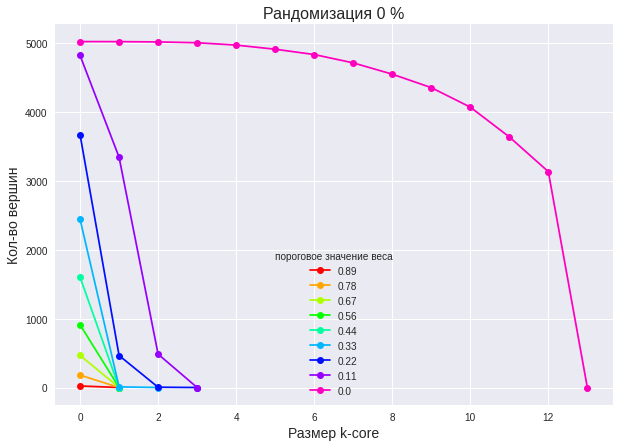

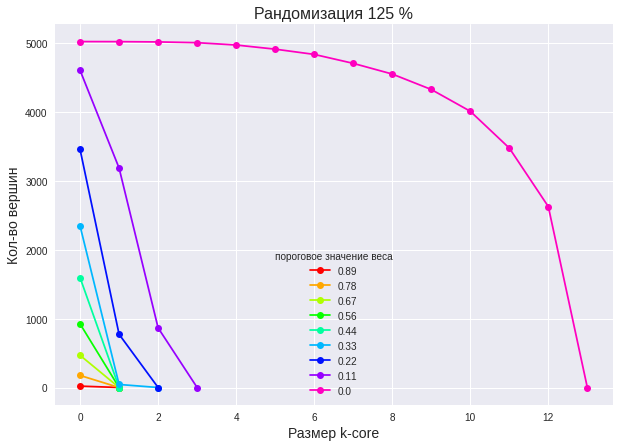

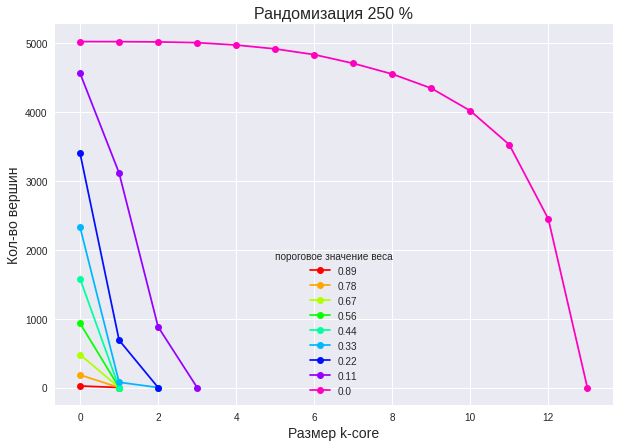

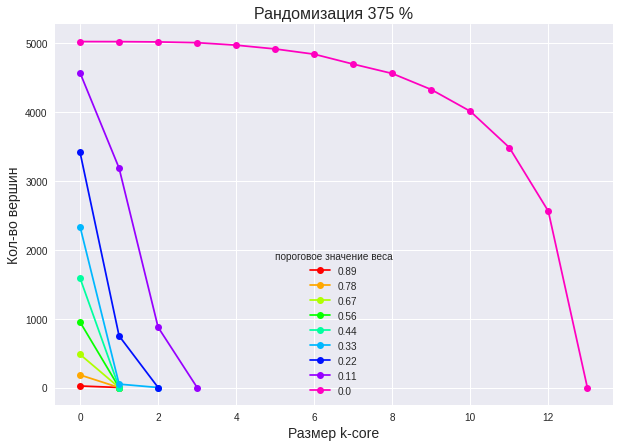

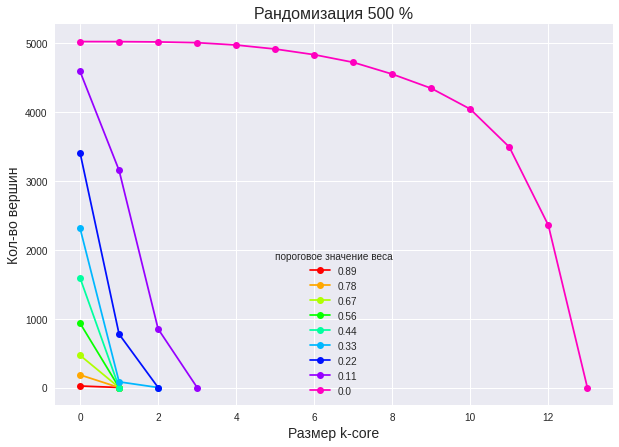

In [170]:
plot_kcore(arr_random, res_k_core_all_r5, max_k, count_k)

## delete

### обновление отрисовки

In [53]:
def plot_of_betti_numbers_del_and_add(key_word,res_betti_all,arr_doly, start_0=1, start_1=1, start_2=1):
    fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(20, 18))
    cmap = get_cmap(len(arr_doly)+1)
#Zero Betti number
    for n in range(len(arr_doly)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        betti1 = [i[1][0] for i in res_copy_rand]
        betti2 = [i[1][1] for i in res_copy_rand]
        betti3 = [i[1][2] for i in res_copy_rand]
        ax[0][0].scatter(ks, betti1,label=(str(int(arr_doly[n]*100))+' %'), color=cmap(n), s=15)
        ax[0][0].set_title('$β_{0}$', fontsize=16)
        ax[0][0].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[0][0].set_ylabel("$β_{0}$", fontsize=14)
        ax[0][0].legend(title=(str(key_word)+' ребра'))
        ax[0][0].set_xlim(1+0.03,0-0.03)

        ax[1][0].scatter(ks, betti1,label=(str(int(arr_doly[n]*100))+' %'), color=cmap(n), s=15)
        ax[1][0].set_title('$β_{0}$', fontsize=16)
        ax[1][0].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[1][0].set_ylabel("$β_{0}$ \n(log шкала)", fontsize=14)
        ax[1][0].legend(title=(str(key_word)+' ребра'))
        ax[1][0].set_yscale('log')
        ax[1][0].set_xlim(start_0+0.03,0-0.03)

        ax[2][0].plot(ks, betti1, 'o--',label=(str(int(arr_doly[n]*100))+' %'), color=cmap(n))
        ax[2][0].set_title('$β_{0}$', fontsize=16)
        ax[2][0].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[2][0].set_ylabel("$β_{0}$ \n(log шкала)", fontsize=14)
        ax[2][0].legend(title=(str(key_word)+' ребра'))
        ax[2][0].set_yscale('log')
        ax[2][0].set_xlim(start_0+0.03,0-0.03)

        ax[0][1].scatter(ks, betti2,label=(str(int(arr_doly[n]*100))+' %'), color=cmap(n), s=15)
        ax[0][1].set_title('$β_{1}$', fontsize=16)
        ax[0][1].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[0][1].set_ylabel("$β_{1}$", fontsize=14)
        ax[0][1].legend(title=(str(key_word)+' ребра'))
        ax[0][1].set_xlim(1+0.03,0-0.03)

        ax[1][1].scatter(ks, betti2,label=(str(int(arr_doly[n]*100))+' %'), color=cmap(n), s=20)
        ax[1][1].set_title('$β_{1}$', fontsize=16)
        ax[1][1].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[1][1].set_ylabel("$β_{1}$ \n(log шкала)", fontsize=14)
        ax[1][1].legend(title=(str(key_word)+' ребра'))
        ax[1][1].set_yscale('log')
        ax[1][1].set_xlim(start_1+0.03,0-0.03)

        ax[2][1].plot(ks, betti2, 'o--',label=(str(int(arr_doly[n]*100))+' %'), color=cmap(n))
        ax[2][1].set_title('$β_{1}$', fontsize=16)
        ax[2][1].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[2][1].set_ylabel("$β_{1}$ \n(log шкала)", fontsize=14)
        ax[2][1].legend(title=(str(key_word)+' ребра'))
        ax[2][1].set_yscale('log')
        ax[2][1].set_xlim(start_1+0.03,0-0.03)

        ax[0][2].scatter(ks, betti3,label=(str(int(arr_doly[n]*100))+' %'), color=cmap(n), s=15)
        ax[0][2].set_title('$β_{2}$', fontsize=16)
        ax[0][2].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[0][2].set_ylabel("$β_{2}$", fontsize=14)
        ax[0][2].legend(title=(str(key_word)+' ребра'))
        ax[0][2].set_xlim(1+0.03,0-0.03)
        
        ax[1][2].scatter(ks, betti3,label=(str(int(arr_doly[n]*100))+' %'), color=cmap(n), s=20)
        ax[1][2].set_title('$β_{2}$', fontsize=16)
        ax[1][2].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[1][2].set_ylabel("$β_{2}$ \n(log шкала)", fontsize=14)
        ax[1][2].legend(title=(str(key_word)+' ребра'))
        ax[1][2].set_yscale('log')
        ax[1][2].set_xlim(start_2+0.03,0-0.03)
        
        ax[2][2].plot(ks, betti3, 'o--',label=(str(int(arr_doly[n]*100))+' %'), color=cmap(n))
        ax[2][2].set_title('$β_{2}$', fontsize=16)
        ax[2][2].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[2][2].set_ylabel("$β_{2}$ \n(log шкала)", fontsize=14)
        ax[2][2].legend(title=(str(key_word)+' ребра'))
        ax[2][2].set_yscale('log')
        ax[2][2].set_xlim(start_2+0.03,0-0.03)

    plt.subplots_adjust(hspace=0.35, wspace=0.2)
    plt.show()

In [54]:
def plot_of_dops_random_del_and_add(key_word,res_betti_all, arr_doly, res_lcg_all, start_size_max_component=1):
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 5))
    cmap = get_cmap(len(arr_doly)+1)
    res_copy_rand = res_dop_Nan(res_betti_all[0])
    ks = [i[0] for i in res_copy_rand]

    for n in range(len(arr_doly)):    
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]
        ax[0].scatter(ks, [i[0] for i in res_lcg_all[n]],color=cmap(n),label=(str(int(arr_doly[n]*100))+' %'), s=15)
        ax[1].scatter(ks, [i[0] for i in res_lcg_all[n]],color=cmap(n),label=(str(int(arr_doly[n]*100))+' %'), s=15)
        ax[2].plot(ks, [i[0] for i in res_lcg_all[n]], 'o--',color=cmap(n),label=(str(int(arr_doly[n]*100))+' %'))

    ax[0].set_xlabel("Пороговое значение веса", fontsize=12)
    ax[0].set_ylabel("Кол-во вершин", fontsize=12)
    ax[0].set_title("Размер максимальной компоненты", fontsize=14)
    ax[0].legend(title=(str(key_word)+' ребра'))
    ax[0].set_xlim(1+0.03,0-0.03)

    ax[1].set_xlabel("Пороговое значение веса", fontsize=12)
    ax[1].set_ylabel("Кол-во вершин \n(log шкала)", fontsize=12)
    ax[1].set_title("Размер максимальной компоненты", fontsize=14)
    ax[1].set_yscale('log')
    ax[1].legend(title=(str(key_word)+' ребра'))
    ax[1].set_xlim(start_size_max_component+0.03,0-0.03)

    ax[2].set_xlabel("Пороговое значение веса", fontsize=12)
    ax[2].set_ylabel("Кол-во вершин \n(log шкала)", fontsize=12)
    ax[2].set_title("Размер максимальной компоненты", fontsize=14)
    ax[2].set_yscale('log')
    ax[2].legend(title=(str(key_word)+' ребра'))
    ax[2].set_xlim(start_size_max_component+0.03,0-0.03)

    plt.subplots_adjust(hspace=0.35, wspace=0.2)
    plt.show()

In [25]:
def plot_kcore_all_in_one_var(arr_random, res_k_core_all, max_k, count_k, without_word, max_word):
    fig = plt.figure(figsize=(20, 10))
    for i in range(len(res_k_core_all)):
        if i==0:
            data = data_kcore(res_k_core_all,i)
            cmap = get_cmap(len(data)+1)
            for n in range(len(data)):
                labels = np.linspace(0, max_k, count_k)[:len(data)][::-1]
                x = range(len(data[n]))
                plt.plot(x, data[n], '--',marker='o',c=cmap(n),label=(str(np.round(labels[n],2))+' (без '+str(without_word)+' )'))

        elif i==len(res_k_core_all)-1:
            data = data_kcore(res_k_core_all,i)
            cmap = get_cmap(len(data)+1)
            for n in range(len(data)):
                labels = np.linspace(0, max_k, count_k)[:len(data)][::-1]
                x = range(len(data[n]))
                plt.plot(x, data[n], ':',marker='o',c=cmap(n),label=(str(np.round(labels[n],2))+' (макс '+str(max_word)+' '+str(int(arr_random[i]*100)))+' %)')        

        else:
            data = data_kcore(res_k_core_all,i)
            cmap = get_cmap(len(data)+1)
            for n in range(len(data)):
                labels = np.linspace(0, max_k, count_k)[:len(data)][::-1]
                x = range(len(data[n]))
                plt.plot(x, data[n], marker='o',c=cmap(n))#,label=np.round(labels[n],2))

        #plt.title(('Доля рандомизации = '+str(np.round(arr_random[i],2))), fontsize=16)
        plt.xlabel('Размер k-core', fontsize=14)
        plt.ylabel('Кол-во вершин', fontsize=14)
        plt.legend(title='пороговое значение веса')#, loc='right')
    plt.title(('Все варианты '+str(without_word)), fontsize=16)

### def

In [22]:
def delete_edges(new_df, doly):
    df_now = new_df.copy()
    number_edges = len(df_now)
    arr_for_delete = np.sort(np.random.choice(number_edges, int(doly*number_edges), replace=False))
    df_now = df_now.drop(arr_for_delete, axis=0).reset_index(drop=True)

    nodes = pd.unique(pd.concat([df_now[df_now.columns[0]], df_now[df_now.columns[1]]]))
    nodes2id = dict(zip(nodes, range(len(nodes))))
    weight_edges = df_now[df_now.columns[-1]] 
    print('с удалением', int(doly*100),'% ребер, кол-во ребер стало:', len(df_now), '(изначально было', number_edges, 'ребер)')

    #симметричная матрица весов 
    A_new = np.zeros((len(nodes),len(nodes)))
    for i, edge in enumerate(zip(df_now[df_now.columns[0]],df_now[df_now.columns[1]])):
        n1, n2 = edge
        ind1 = nodes2id[n1]# np.where(nodes == n1)[0][0]
        ind2 = nodes2id[n2]# np.where(nodes == n2)[0][0]
        A_new[ind1][ind2] = weight_edges[i]
        A_new[ind2][ind1] = weight_edges[i]
    return A_new

### plot

In [55]:
max_k = 1 
count_k = 100
arr_doly = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
res_betti_all = []
res_lcg_all = []
for doly in arr_doly:
    A_new = delete_edges(new_df, doly)
    res_betti_,res_lcg_ = betti_numbers_and_dops(A_new, max_k, count_k)
    res_betti_all.append(res_betti_)
    res_lcg_all.append(res_lcg_)

с удалением 0 % ребер, кол-во ребер стало: 55242 (изначально было 55242 ребер)


  0%|          | 0/100 [00:00<?, ?it/s]

с удалением 10 % ребер, кол-во ребер стало: 49718 (изначально было 55242 ребер)


  0%|          | 0/100 [00:00<?, ?it/s]

с удалением 20 % ребер, кол-во ребер стало: 44194 (изначально было 55242 ребер)


  0%|          | 0/100 [00:00<?, ?it/s]

с удалением 30 % ребер, кол-во ребер стало: 38670 (изначально было 55242 ребер)


  0%|          | 0/100 [00:00<?, ?it/s]

с удалением 40 % ребер, кол-во ребер стало: 33146 (изначально было 55242 ребер)


  0%|          | 0/100 [00:00<?, ?it/s]

с удалением 50 % ребер, кол-во ребер стало: 27621 (изначально было 55242 ребер)


  0%|          | 0/100 [00:00<?, ?it/s]

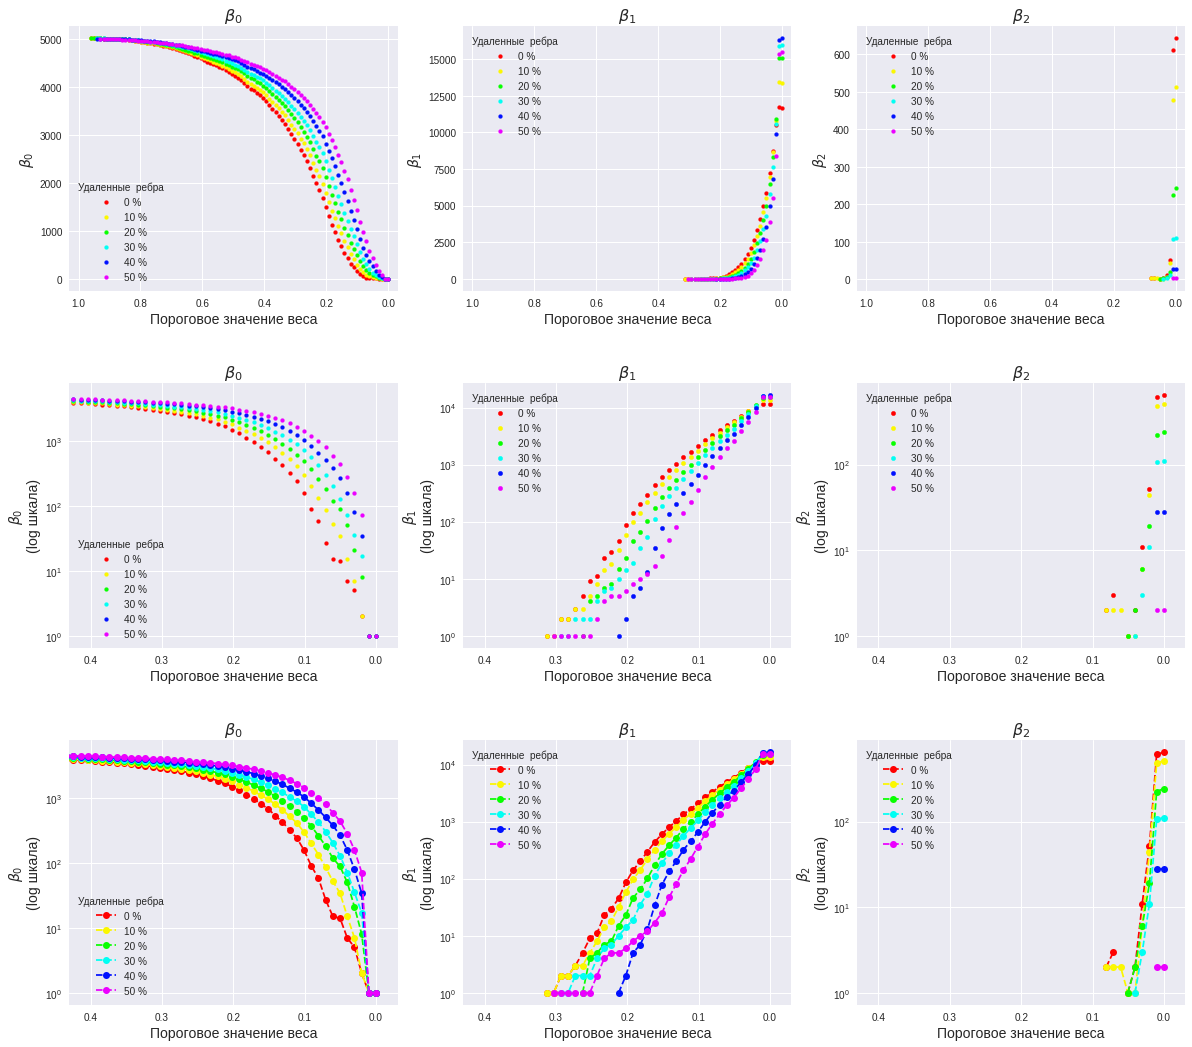

In [57]:
plot_of_betti_numbers_del_and_add("Удаленные ",res_betti_all,arr_doly, 0.4, 0.4, 0.4)

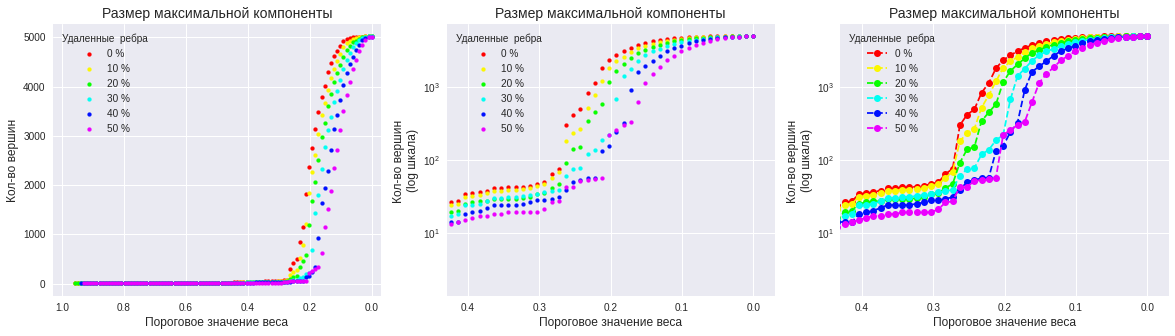

In [58]:
plot_of_dops_random_del_and_add("Удаленные ",res_betti_all, arr_doly, res_lcg_all, 0.4)

In [59]:
max_k = 1 
count_k = 10
arr_doly = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
res_betti_all = []
res_kcore_all = []
for doly in arr_doly:
    A_new = delete_edges(new_df, doly)
    res_betti_, res_k_core_ = betti_numbers_and_dops_with_k_core(A_new, max_k, count_k)
    res_betti_all.append(res_betti_)
    res_kcore_all.append(res_k_core_)

с удалением 0 % ребер, кол-во ребер стало: 55242 (изначально было 55242 ребер)


  0%|          | 0/10 [00:00<?, ?it/s]

с удалением 10 % ребер, кол-во ребер стало: 49718 (изначально было 55242 ребер)


  0%|          | 0/10 [00:00<?, ?it/s]

с удалением 20 % ребер, кол-во ребер стало: 44194 (изначально было 55242 ребер)


  0%|          | 0/10 [00:00<?, ?it/s]

с удалением 30 % ребер, кол-во ребер стало: 38670 (изначально было 55242 ребер)


  0%|          | 0/10 [00:00<?, ?it/s]

с удалением 40 % ребер, кол-во ребер стало: 33146 (изначально было 55242 ребер)


  0%|          | 0/10 [00:00<?, ?it/s]

с удалением 50 % ребер, кол-во ребер стало: 27621 (изначально было 55242 ребер)


  0%|          | 0/10 [00:00<?, ?it/s]

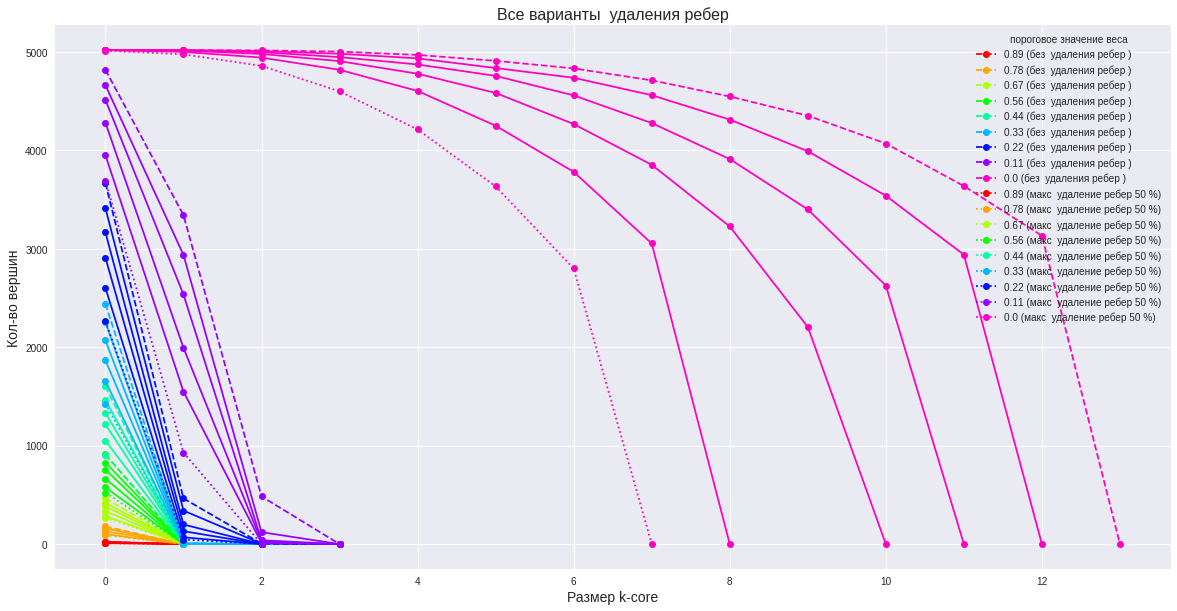

In [61]:
plot_kcore_all_in_one_var(arr_doly, res_kcore_all, max_k, count_k, " удаления ребер", " удаление ребер")

## add

### def

In [62]:
def add_edges(new_df, doly):
    df_now = new_df.copy()
    number_edges = len(df_now)
    arr_weights_for_add = np.random.choice(df_now[df_now.columns[-1]], int(doly*number_edges), replace=True)

    for k in range(len(arr_weights_for_add)):
        i = 0
        nodes = pd.unique(pd.concat([df_now[df_now.columns[0]], df_now[df_now.columns[1]]]))
        edges = list(zip(df_now[df_now.columns[0]],df_now[df_now.columns[1]])) 
        while i==0:
            n1,n2 = np.random.choice(nodes, 2, replace=False)
            if (n1,n2) not in edges and (n2,n1) not in edges:
                new_row = {df_now.columns[0]: n1, df_now.columns[1]: n2, df_now.columns[2]: arr_weights_for_add[k]}
                df_now = df_now.append(new_row, ignore_index = True)
                i = 1
            else:
                i = 0
    df_now = df_now.reset_index(drop=True)


    nodes = pd.unique(pd.concat([df_now[df_now.columns[0]], df_now[df_now.columns[1]]]))
    nodes2id = dict(zip(nodes, range(len(nodes))))
    weight_edges = df_now[df_now.columns[-1]] 
    print('с добавлением', int(doly*100),'% ребер, кол-во ребер стало:', len(df_now), '(изначально было', number_edges, 'ребер)')

    #симметричная матрица весов 
    A_new = np.zeros((len(nodes),len(nodes)))
    for i, edge in enumerate(zip(df_now[df_now.columns[0]],df_now[df_now.columns[1]])):
        n1, n2 = edge
        ind1 = nodes2id[n1]# np.where(nodes == n1)[0][0]
        ind2 = nodes2id[n2]# np.where(nodes == n2)[0][0]
        A_new[ind1][ind2] = weight_edges[i]
        A_new[ind2][ind1] = weight_edges[i]

    return A_new

### plot

In [ ]:
max_k = 1 
count_k = 100
arr_doly = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
res_betti_all = []
res_lcg_all = []
for doly in arr_doly:
    A_new = add_edges(new_df, doly)
    res_betti_,res_lcg_ = betti_numbers_and_dops(A_new, max_k, count_k)
    res_betti_all.append(res_betti_)
    res_lcg_all.append(res_lcg_)

с добавлением 0 % ребер, кол-во ребер стало: 55242 (изначально было 55242 ребер)


  0%|          | 0/100 [00:00<?, ?it/s]

с добавлением 10 % ребер, кол-во ребер стало: 60766 (изначально было 55242 ребер)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
plot_of_betti_numbers_del_and_add("Добавленные ",res_betti_all,arr_doly, 0.4, 0.4, 0.4)

In [ ]:
plot_of_dops_random_del_and_add("Добавленные ",res_betti_all, arr_doly, res_lcg_all, 0.4)

In [ ]:
max_k = 1 
count_k = 10
arr_doly = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
res_betti_all = []
res_kcore_all = []
for doly in arr_doly:
    A_new = add_edges(new_df, doly)
    res_betti_, res_k_core_ = betti_numbers_and_dops_with_k_core(A_new, max_k, count_k)
    res_betti_all.append(res_betti_)
    res_kcore_all.append(res_k_core_)

In [ ]:
plot_kcore_all_in_one_var(arr_doly, res_kcore_all, max_k, count_k, " добавления ребер", " добавление ребер")

## subgraph

### def

In [27]:
def make_subgraph(noda, Matr, max_length):
    G = nx.from_numpy_array(Matr)
    structure_subgraph = nx.dfs_successors(G, source=noda, depth_limit=max_length)
    nodes_subgraph = np.sort([x for sub in structure_subgraph.values() for x in sub])
    Matr_new = Matr[nodes_subgraph][:, nodes_subgraph]
    return Matr_new, nodes_subgraph

In [46]:
def plot_of_betti_numbers(res, arr_len,start_0=1,start_1=1,start_2=1):
    fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(20, 18))
    cmap = get_cmap(len(res)+1)
    for m in range(len(res)):
        res_copy = res_dop_Nan(res[m])
        ks = [i[0] for i in res_copy]
        betti1 = [i[1][0] for i in res_copy]
        betti2 = [i[1][1] for i in res_copy] 
        betti3 = [i[1][2] for i in res_copy]

        ax[0][0].scatter(ks, betti1, s=15, color=cmap(m), label=(str(int(arr_len[m]))+str(' вершин')))
        ax[0][0].set_title('$β_{0}$', fontsize=16)
        ax[0][0].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[0][0].set_ylabel("$β_{0}$", fontsize=14)
        ax[0][0].legend(title=('Размер подграфа'))
        ax[0][0].set_xlim(1+0.03,0-0.03)

        ax[0][1].scatter(ks, betti2,color=cmap(m), s=15, label=(str(int(arr_len[m]))+str(' вершин')))
        ax[0][1].set_title('$β_{1}$', fontsize=16)
        ax[0][1].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[0][1].set_ylabel("$β_{1}$", fontsize=14)
        ax[0][1].legend(title=('Размер подграфа'))
        ax[0][1].set_xlim(1+0.03,0-0.03)

        ax[0][2].scatter(ks, betti3,color=cmap(m), s=20, label=(str(int(arr_len[m]))+str(' вершин')))
        ax[0][2].set_title('$β_{2}$', fontsize=16)
        ax[0][2].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[0][2].set_ylabel("$β_{2}$", fontsize=14)
        ax[0][2].legend(title=('Размер подграфа'))
        ax[0][2].set_xlim(1+0.03,0-0.03)

        ax[1][0].scatter(ks, betti1,color=cmap(m), s=15, label=(str(int(arr_len[m]))+str(' вершин')))
        ax[1][0].set_title('$β_{0}$', fontsize=16)
        ax[1][0].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[1][0].set_ylabel("$β_{0}$ (log шкала)", fontsize=14)
        ax[1][0].legend(title=('Размер подграфа'))
        ax[1][0].set_yscale('log')
        ax[1][0].set_xlim(start_0+0.03,0-0.03)

        ax[1][1].scatter(ks, betti2,color=cmap(m), s=15, label=(str(int(arr_len[m]))+str(' вершин')))
        ax[1][1].set_title('$β_{1}$', fontsize=16)
        ax[1][1].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[1][1].set_ylabel("$β_{1}$ (log шкала)", fontsize=14)
        ax[1][1].legend(title=('Размер подграфа'))
        ax[1][1].set_yscale('log')
        ax[1][1].set_xlim(start_1+0.03,0-0.03)

        ax[1][2].scatter(ks, betti3,color=cmap(m), s=20, label=(str(int(arr_len[m]))+str(' вершин')))
        ax[1][2].set_title('$β_{2}$', fontsize=16)
        ax[1][2].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[1][2].set_ylabel("$β_{2}$ (log шкала)", fontsize=14)
        ax[1][2].legend(title=('Размер подграфа'))
        ax[1][2].set_yscale('log')
        ax[1][2].set_xlim(start_2+0.03,0-0.03)

        ax[2][0].plot(ks, betti1,color=cmap(m),marker='o', label=(str(int(arr_len[m]))+str(' вершин')))
        ax[2][0].set_title('$β_{0}$', fontsize=16)
        ax[2][0].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[2][0].set_ylabel("$β_{0}$ (log шкала)", fontsize=14)
        ax[2][0].legend(title=('Размер подграфа'))
        ax[2][0].set_yscale('log')
        ax[2][0].set_xlim(start_0+0.03,0-0.03)

        ax[2][1].plot(ks, betti2,'o--',color=cmap(m), label=(str(int(arr_len[m]))+str(' вершин')))
        ax[2][1].set_title('$β_{1}$', fontsize=16)
        ax[2][1].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[2][1].set_ylabel("$β_{1}$ (log шкала)", fontsize=14)
        ax[2][1].legend(title=('Размер подграфа'))
        ax[2][1].set_yscale('log')
        ax[2][1].set_xlim(start_1+0.03,0-0.03)

        ax[2][2].plot(ks, betti3,'o--',color=cmap(m), label=(str(int(arr_len[m]))+str(' вершин')))
        ax[2][2].set_title('$β_{2}$', fontsize=16)
        ax[2][2].set_xlabel("Пороговое значение веса", fontsize=14)
        ax[2][2].set_ylabel("$β_{2}$ (log шкала)", fontsize=14)
        ax[2][2].legend(title=('Размер подграфа'))
        ax[2][2].set_yscale('log')
        ax[2][2].set_xlim(start_2+0.03,0-0.03)

    plt.show()

In [45]:
def plot_of_dops_subgraph_lcg(res_betti_all, arr_len, res_lcg_all, start_size_max_component=1):
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 5))
    cmap = get_cmap(len(arr_len)+1)

    for n in range(len(arr_len)): 
        res_copy_rand = res_dop_Nan(res_betti_all[n])
        ks = [i[0] for i in res_copy_rand]   
        ax[0].scatter(ks, [i[0] for i in res_lcg_all[n]],color=cmap(n), s=15,label=(str(int(arr_len[n]))+str(' вершин')))
        ax[1].scatter(ks, [i[0] for i in res_lcg_all[n]],color=cmap(n),s=15,label=(str(int(arr_len[n]))+str(' вершин')))
        ax[2].plot(ks, [i[0] for i in res_lcg_all[n]], 'o--',color=cmap(n),label=(str(int(arr_len[n]))+str(' вершин')))

    ax[0].set_xlabel("Пороговое значение веса", fontsize=12)
    ax[0].set_ylabel("Кол-во вершин", fontsize=12)
    ax[0].set_title("Размер максимальной компоненты", fontsize=14)
    ax[0].legend(title=('Размер подграфа'))
    ax[0].set_xlim(1+0.03,0-0.03)

    ax[1].set_xlabel("Пороговое значение веса", fontsize=12)
    ax[1].set_ylabel("Кол-во вершин \n(log шкала)", fontsize=12)
    ax[1].set_title("Размер максимальной компоненты", fontsize=14)
    ax[1].set_yscale('log')
    ax[1].legend(title=('Размер подграфа'))
    ax[1].set_xlim(start_size_max_component+0.03,0-0.03)

    ax[2].set_xlabel("Пороговое значение веса", fontsize=12)
    ax[2].set_ylabel("Кол-во вершин \n(log шкала)", fontsize=12)
    ax[2].set_title("Размер максимальной компоненты", fontsize=14)
    ax[2].set_yscale('log')
    ax[2].legend(title=('Размер подграфа'))
    ax[2].set_xlim(start_size_max_component+0.03,0-0.03)

    plt.subplots_adjust(hspace=0.35, wspace=0.2)
    plt.show()

In [51]:
def plot_kcore_all_in_one_subgraph(arr_random, res_k_core_all, max_k, count_k):
    fig = plt.figure(figsize=(20, 10))
    for i in range(len(res_k_core_all)):
        if i==0:
            data = data_kcore(res_k_core_all,i)
            cmap = get_cmap(len(data)+1)
            for n in range(len(data)):
                labels = np.linspace(0, max_k, count_k)[:len(data)][::-1]
                x = range(len(data[n]))
                plt.plot(x, data[n], '--',marker='o',c=cmap(n),label=(str(np.round(labels[n],2))+' (мин вершин = '+str(int(arr_random[i])))+' )')   

        elif i==len(res_k_core_all)-1:
            data = data_kcore(res_k_core_all,i)
            cmap = get_cmap(len(data)+1)
            for n in range(len(data)):
                labels = np.linspace(0, max_k, count_k)[:len(data)][::-1]
                x = range(len(data[n]))
                plt.plot(x, data[n], ':',marker='o',c=cmap(n),label=(str(np.round(labels[n],2))+' (макс вершин '+str(int(arr_random[i])))+' )')        

        else:
            data = data_kcore(res_k_core_all,i)
            cmap = get_cmap(len(data)+1)
            for n in range(len(data)):
                labels = np.linspace(0, max_k, count_k)[:len(data)][::-1]
                x = range(len(data[n]))
                plt.plot(x, data[n], marker='o',c=cmap(n))#,label=np.round(labels[n],2))

        #plt.title(('Доля рандомизации = '+str(np.round(arr_random[i],2))), fontsize=16)
        plt.xlabel('Размер k-core', fontsize=14)
        plt.ylabel('Кол-во вершин', fontsize=14)
        plt.legend(title='Пороговое значение веса')#, loc='right')
    plt.title('Все варианты', fontsize=16)

### plot

In [30]:
max_k = 1 
count_k = 100
size = 5
nodes_for_subgraphs = np.random.choice(nodes, size, replace=False)

res_betti_all = []
res_lcg_all = []
res_len = []

for i in nodes_for_subgraphs:
    source=list(nodes).index(i)
    A_new, nodes_subgraph = make_subgraph(source, A, max_length=3)
    res_len.append(len(nodes_subgraph))
    res_betti_,res_lcg_ = betti_numbers_and_dops(A_new, max_k, count_k)
    res_betti_all.append(res_betti_)
    res_lcg_all.append(res_lcg_)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
res_len_sort = np.sort(res_len)
res_betti_all_sort = [res_betti_all[res_len.index(i)] for i in res_len_sort]
res_lcg_all_sort = [res_lcg_all[res_len.index(i)] for i in res_len_sort]

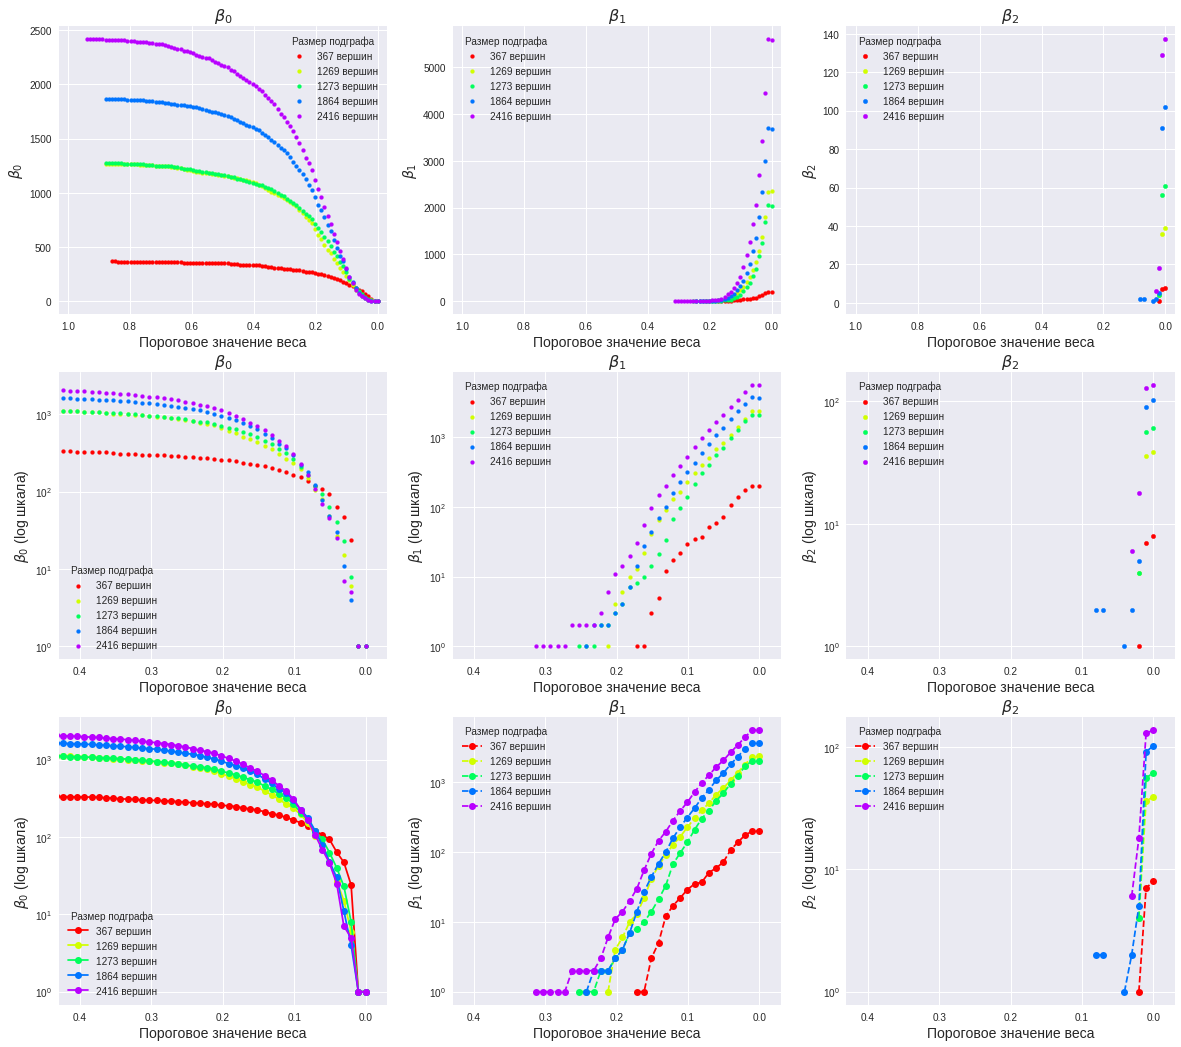

In [47]:
plot_of_betti_numbers(res_betti_all_sort, res_len_sort,0.4,0.4,0.4)

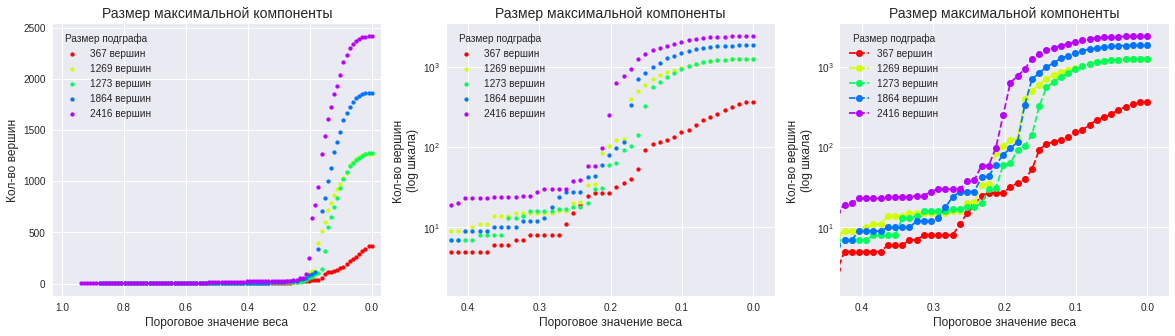

In [48]:
plot_of_dops_subgraph_lcg(res_betti_all_sort, res_len_sort, res_lcg_all_sort, start_size_max_component=0.4)

In [49]:
max_k = 1 
count_k = 10
size = 5
nodes_for_subgraphs = np.random.choice(nodes, size, replace=False)

res_betti_all = []
res_len = []
res_kcore_all = []

for i in nodes_for_subgraphs:
    source=list(nodes).index(i)
    A_new, nodes_subgraph = make_subgraph(source, A, max_length=3)
    res_len.append(len(nodes_subgraph))
    res_betti_, res_k_core_ = betti_numbers_and_dops_with_k_core(A_new, max_k, count_k)
    res_betti_all.append(res_betti_)
    res_kcore_all.append(res_k_core_)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [50]:
res_len_sort = np.sort(res_len)
res_kcore_all_sort = [res_kcore_all[res_len.index(i)] for i in res_len_sort]

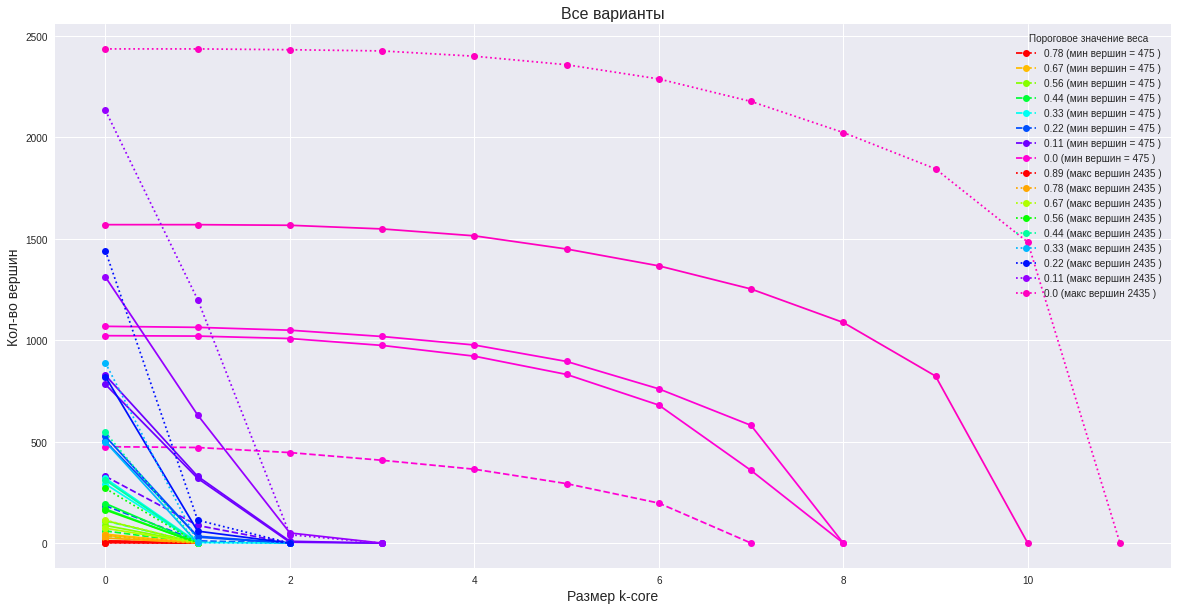

In [52]:
plot_kcore_all_in_one_subgraph(res_len_sort, res_kcore_all_sort, max_k, count_k)